In [1]:
# from network.Gamma2DCropPaste import StackTPredict, UNet, StackSequenceT , Gamma2DCropPaste, Gamma2DNet
from network.mapGeneratorNet import LSTMNet, Generator, GeneratorPredict

import torch
import numpy as np 
from common.readFiles import *
from common.evaluateModelTools import *
from matplotlib import pyplot as plt
from policy.PytorchTraining import PytorchRunner
import matplotlib.ticker as ticker
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from common.math import *



In [2]:
params = {'legend.fontsize': 16,
          'figure.figsize': (15, 5),
         'axes.labelsize': 16,
         'axes.titlesize':16,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
plt.rcParams.update(params)

In [33]:
map_x = 5
variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position", "centroids", "source_detect"]

# datas = []
# for map_x in [5, 10, 20]:
map_x = 5
file_type = "cyclone"
path = "../output/data/processedData/voroni/"+file_type+"/{}/".format(map_x)
data = getData(path, variables) 
source_pos, source_region, X_input, source_concentration, water_flow_force, source_inside, distance_map, source_detect, source_distance, agent_action, agent_pos, centroids, source_detect = data


source_distance = torch.cdist(source_pos, torch.tensor([[0, 0]], dtype=torch.float)).squeeze(-1)

In [34]:
torch.sum(X_input[...,0]>0)/np.product(source_detect.shape)

tensor(0.0960)

In [35]:
source_detect.shape

torch.Size([12000, 120])

In [36]:
torch.sum(X_input[..., 0]>0)

tensor(138175)

In [37]:
np.product(source_detect.shape)

1440000

In [38]:
# def createMask(source_inside, source_detect):
#     mask_inside_with_detect = source_inside * source_detect
#     mask_inside_no_detect = source_inside * (1 - source_detect)
#     mask_outside_with_detect = (1 - source_inside) * source_detect
#     mask_outside_no_detect = (1 - source_inside) * (1 - source_detect)

#     masks = [mask_inside_with_detect, mask_inside_no_detect, mask_outside_with_detect, mask_outside_no_detect]
    
#     return masks

<ipython-input-39-06841a612269>:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels = labels, loc = 'lower center', prop={'size': 16})


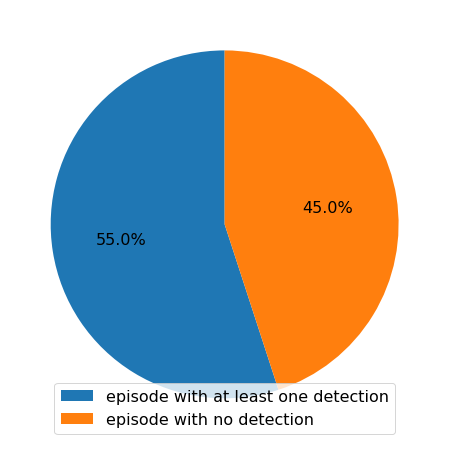

In [39]:
plt.rcParams['figure.facecolor'] = 'white'
# ax.set_facecolor('w')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index


detect = np.sum(source_detect.numpy().max(axis= 1))/len(source_detect)

labels = ["episode with at least one detection", "episode with no detection"]
datas = [detect, 1- detect]
patches, text, _ = ax.pie(datas, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})

# ax.legend(loc = 2, labels = *labels)
plt.legend(patches, labels = labels, loc = 'lower center', prop={'size': 16})
plt.show()

<ipython-input-40-b75a09773d85>:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels = labels, loc = 'lower center')#, prop={'size': 16})


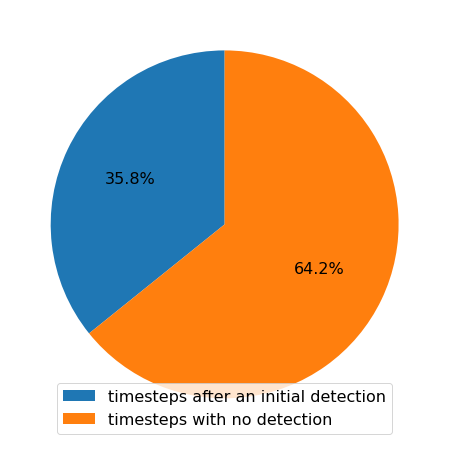

In [40]:
# plt.rcParams['figure.facecolor'] = 'white'
ax.set_facecolor('w')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

detect = torch.sum(source_detect).item() / np.product(source_detect.shape)

labels = ["timesteps after an initial detection", "timesteps with no detection"]
datas = [detect, 1- detect]
patches, text, _ = ax.pie(datas, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})
# ax.legend(loc = 2, labels = *labels)
plt.legend(patches, labels = labels, loc = 'lower center')#, prop={'size': 16})
plt.show()

In [41]:
def sourceDistanceHist(data, blue = True):
    
    if blue:
        color = '#1f77b4'
    else: color = '#ff7f0e'
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    count, bins, ignored = ax.hist(source_distance_detect, bins='auto', density=True, color = color)
    ax.axvline(x = 200, color = 'r')
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 0.1))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.set_xlim(0, 450)
    ax.set_xlabel("distance to source (m)")#, fontsize=16)

    plt.show()

# mask = source_detect.numpy().astype(np.bool)
source_distance_detect = source_distance[source_detect.type(torch.bool)].numpy()
# source_distance_detect = source_distance[mask].numpy()
source_distance_no_detect = source_distance[(1-source_detect).type(torch.bool)].numpy()
# source_distance_no_detect = source_distance[(1-mask).astype(np.bool)].numpy()
print(source_distance_detect.shape)
print(source_distance_no_detect.shape)

(515236,)
(924764,)


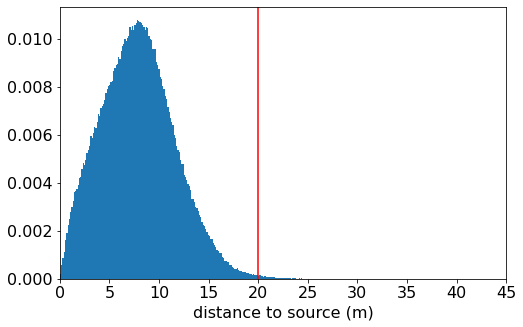

In [42]:
sourceDistanceHist(source_distance_detect)

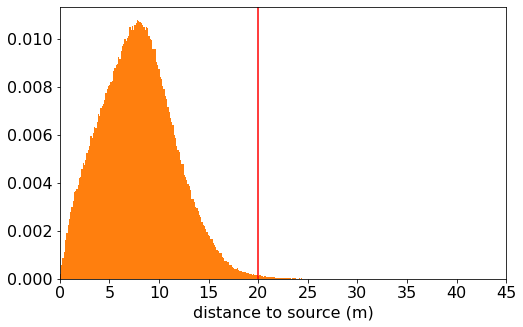

In [43]:
sourceDistanceHist(source_distance_no_detect, blue= False)

In [44]:
source_pos_origin = (source_pos + agent_pos)[:,0]
n_episode = 5000
done = np.zeros(agent_pos.shape[:-1] +(1,)).astype(np.bool)

agent_centric_map, source_centric_map, water_centric_map = processMap(agent_pos.numpy()[:n_episode], source_pos_origin.numpy()[:n_episode],
                                                                                  water_flow_force.numpy()[:n_episode], done[:n_episode])

<ipython-input-44-65e92db2e3df>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.zeros(agent_pos.shape[:-1] +(1,)).astype(np.bool)


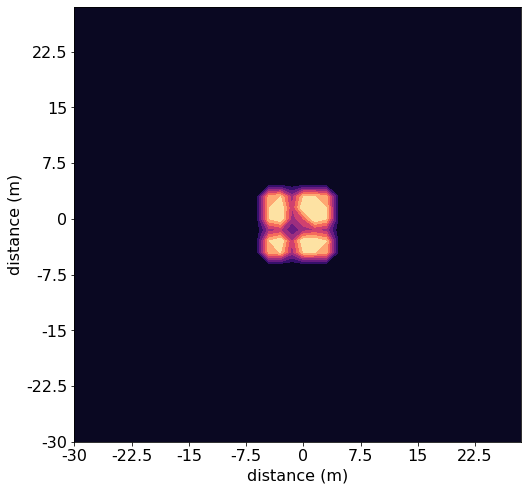

In [45]:
shownMap(agent_centric_map)

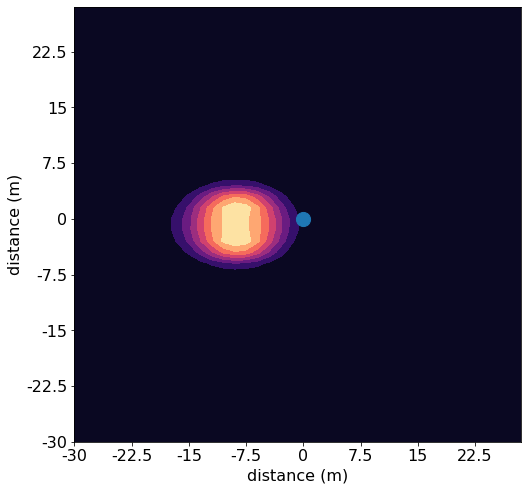

In [46]:
shownMap(source_centric_map, source=True)

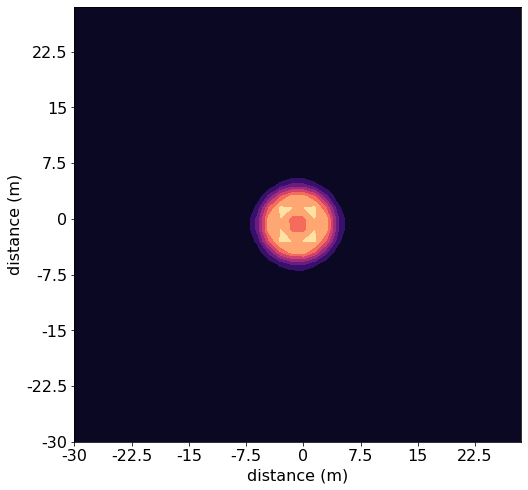

In [47]:
shownMap(water_centric_map)